# <center> FARGO3D - RADMC3D

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'inferno'
%run functions.ipynb


In [15]:
import numpy as np
import matplotlib.pyplot as plt

slice = 100

for i in range(slice):
    """Para ver los planetas"""

    # Load the gas density data from the file
    data = np.fromfile(f'/home/jupitergeci/fargo3d/outputs/fargo_sizes/gasdens{i:01d}.dat',                 dtype=np.float64)

    # Load the domain_x.dat, domain_y.dat, and domain_z.dat files
    domain_x = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_x.dat')        # coordenada azimuthal theta
    domain_y = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_y.dat')[3:-3]  # coordenada radial r
    domain_z = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_z.dat')[3:-3]  # coordenada co-latitud phi

    # Get the dimensions of the data grid
    NZ, NY, NX = len(domain_z)-1, len(domain_y)-1, len(domain_x)-1

    #print(NZ, NY, NX)

    # Reshape the data array to match the dimensions of the grid
    data = data.reshape(NZ, NY, NX)

    # Select a slice along the phi-axis (the first dimension)
    slice_index = NZ // 2  # Middle of the phi-axis
    data_slice = data[slice_index, :, :]

    # Define functions to create the X, Y, and Z grids
    def Grilla_XY():
        # Create 2D grids
        R = 0.5 * (domain_y[1:] + domain_y[:-1])
        Phi = 0.5 * (domain_x[1:] + domain_x[:-1]) #En Fargo theta (azimuth) -> phi (coodenada X)
        P, R = np.meshgrid(Phi, R)
        # Convert the cylindrical coordinates (R, P) to Cartesian coordinates (X, Y)
        X, Y = R*np.cos(P), R*np.sin(P)
        return X, Y


    X,Y = Grilla_XY()

    # Select a slice along the phi-axis (the first dimension)

    top = int( NZ // 1)- 1  # top of the phi-axis
    mid = NZ // 2          # Middle of the phi-axis
    slice_index = mid # Dónde se hace el corte
    data_slice = data[slice_index, :, :]




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def update_plot(frame):
    """Update the plot for the current frame"""

    # Upload data
    data = np.fromfile(f'/home/jupitergeci/fargo3d/outputs/fargo_sizes/gasdens{frame:01d}.dat', dtype=np.float64)
    data = data.reshape(NZ, NY, NX)
    data_slice = data[slice_index, :, :]

    
    plt.clf()
    plt.pcolormesh(X, Y, data_slice, cmap='inferno')
    plt.colorbar(label='Density')
    plt.title(f'Gas Density Visualization (Phi-slice at index {slice_index}) - Frame {frame+1}')
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.axis('equal')
    plt.style.use("dark_background")

    return plt.gcf(),

# Upload grid data boundaries
domain_x = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_x.dat')
domain_y = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_y.dat')[3:-3]
domain_z = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_z.dat')[3:-3]
NZ, NY, NX = len(domain_z)-1, len(domain_y)-1, len(domain_x)-1
slice_index = NZ // 2
X, Y = Grilla_XY()

fig = plt.figure(figsize=(10, 10),facecolor="black")
anim = FuncAnimation(fig, update_plot, frames=slice, interval=200)  # 3 frames, intervalo de 200 ms

anim.save('gas_density_visualization.gif', writer='imagemagick')


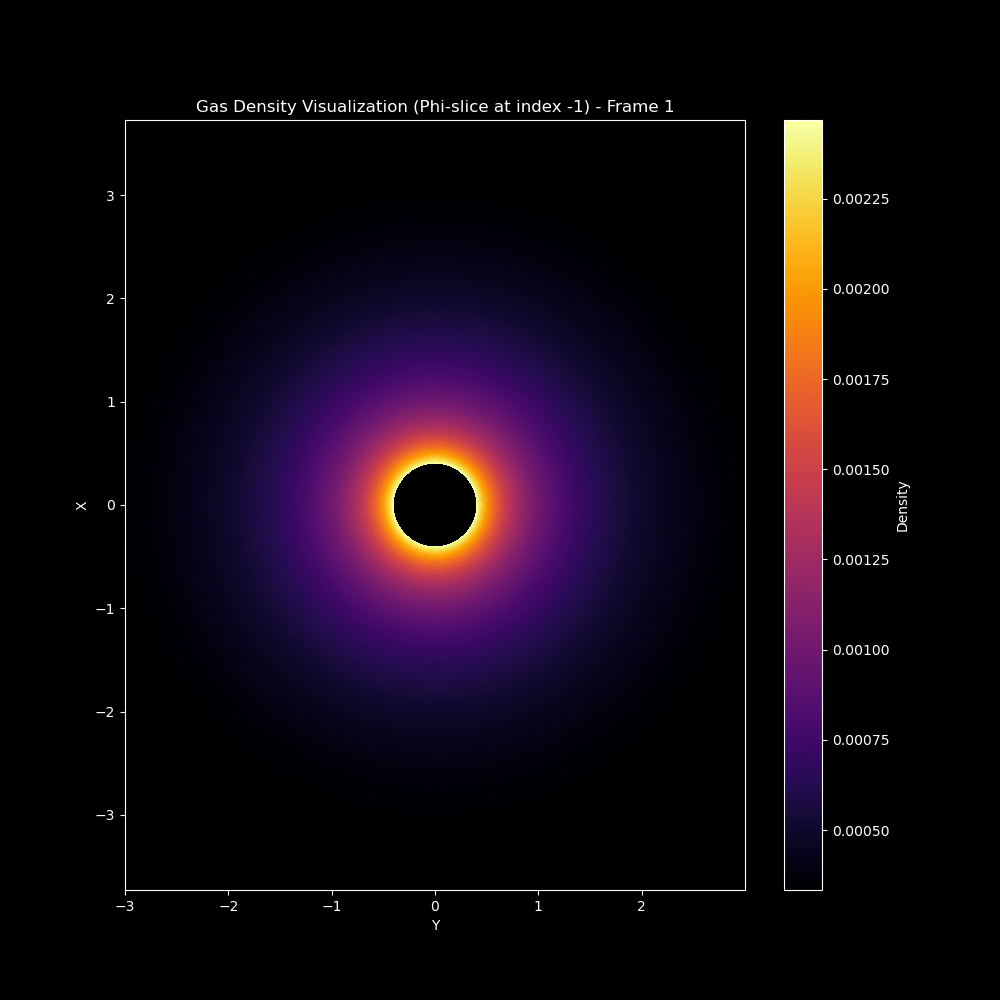

In [18]:
from IPython.display import Image

gif = open('gas_density_visualization.gif', 'rb').read()

Image(gif)

# This cell reads the data for the cell divisions and parameters used in the FARGO3D simulation


In [19]:
class read_parameters():
    def __init__(self, path=''):
        params = open(path+"variables.par",'r')
        lines = params.readlines()     # reading parfile                                                                                                                                       
        params.close()                 # closing parfile                                                                                                                                       
        par = {}                       # allocating a dictionary                                                                                                                               
        for line in lines:             # iterating over parfile                                                                                                                                
            name, value = line.split() # spliting name and value (first blank)                                                                                                                 
            try:
                float(value)           # first trying with float                                                                                                                               
            except ValueError:         # if it is not float                                                                                                                                    
                try:
                    int(value)         # we try with integer                                                                                                                                   
                except ValueError:     # if it is not integer, we know it is string                                                                                                            
                    value = '"' + value + '"'
            par[name] = value          # filling variable                                                                                                                                      
        self._params = par             # control atribute, good for debbuging                                                                                                                  
        for name in par:               # iterating over the dictionary                                                                                                                         
            exec("self."+name.lower()+"="+par[name]) # making atributes at runtime

class hydro_grid():
    def __init__(self,path=""):
        try:
            self.x = np.loadtxt(path+"domain_x.dat")+np.pi # AZIMUTH                                                                                                                          
        except IOError:
            print("IOError with domain_x.dat")
        try:
            self.y = np.loadtxt(path+"domain_y.dat")[3:-3] # RADIUS                                                                                                                     
        except IOError:
            print("IOError with domain_y.dat")
        try:
            self.z = np.loadtxt(path+"domain_z.dat")[3:-3] # COLATITUDE                                                                                                                 
        except:
            print("No vertical domain found - Is the simulation 2D?")

## Reading the results of the FARGO3D simulation

[0.001, 0.01, 0.1]


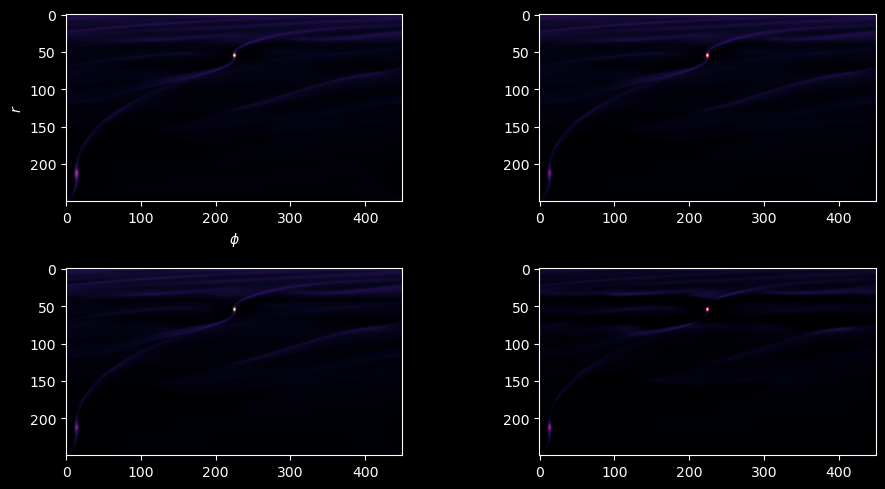

In [22]:
au = 1.5e13 # cm
msun= 2e33  # gr 
rjup=5.2*au 

fargodir = '/home/jupitergeci/fargo3d/outputs/fargo_sizes/'
t = 80
par = read_parameters(path=fargodir)
gridF = hydro_grid(path=fargodir)
ndust = 3
names = ['gas','dust1','dust2','dust3']
dens = []
sizes= []
St   = []
dens.append(np.fromfile(fargodir+'gasdens%d.dat'%t).reshape(par.ny,par.nx))
for i in range(1,ndust+1):
    dens.append(np.fromfile(fargodir+names[i]+'dens%d.dat'%t).reshape(par.ny,par.nx))
    dens[i-1] *= par.mfactor*msun/(par.rfactor*rjup)**2
    sizes.append(par.amin*pow((par.amax/par.amin),(i-1.0)/(ndust-1.0)))
    St.append(np.pi/2.0*sizes[i-1]*par.rho_solid/dens[0])
print(sizes)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,5))
ax1.imshow(dens[0],vmax = dens[0].max()/2)
ax2.imshow(dens[1],vmax = dens[1].max()/2)
ax3.imshow(dens[2],vmax = dens[2].max()/2)
ax4.imshow(dens[3],vmax = dens[3].max()/2)

ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel(r'$r$')
plt.tight_layout()
plt.show()


## MESHGRID setup for RADMC3D


In [23]:
###Define grid similar to introduction but including the polar direction with theta = [pi/2-0.3,pi/2]###
class grid:
    def __init__(self,dims,bounds):
        self.nr, self.ntheta, self.nphi = dims[0],dims[1],dims[2]
        self.use_r  = 1 if self.nr > 1 else 0     # Which directions are included? 
        self.use_theta = 1 if self.ntheta > 1 else 0
        self.use_phi = 1 if self.nphi > 1 else 0
        self.theta_face = np.linspace(bounds[2],bounds[3],self.ntheta+1)
        self.theta = 0.5*(self.theta_face[1:]+self.theta_face[:-1])
        
r_in, r_out = par.ymin*par.rfactor*rjup, par.ymin*par.rfactor*rjup
if par.nz == 1:
    theta_up,theta_down = np.pi/2-0.3,np.pi/2+0.3
phi_l, phi_r = par.xmin,par.xmax
bounds = [r_in,r_out,theta_up,theta_down,phi_l,phi_r]
grid1 = grid([par.ny,50,par.nx],bounds) # This produces a 1D grid with 100 cells in radial direction
grid1.r0 = par.rfactor*rjup
grid1.r_face = gridF.y*grid1.r0
grid1.r = 0.5*(grid1.r_face[1:]+grid1.r_face[:-1])
grid1.phi_face   = gridF.x
grid1.phi = 0.5*(grid1.phi_face[1:]+grid1.phi_face[:-1])
grid_inp(grid1)                # this writes a file called 'amr_grid.inp' needed to run RADMC-3D

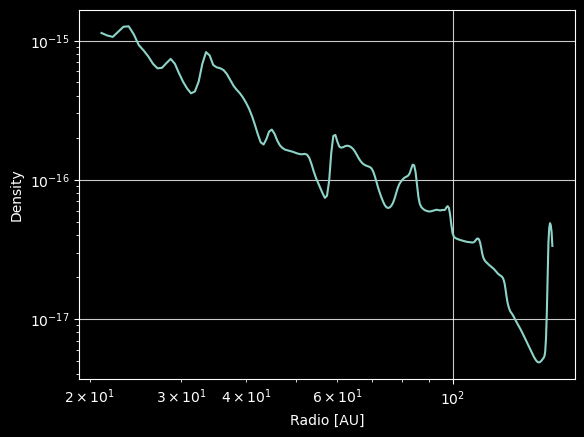

/tmp/ipykernel_5423/3241501153.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(rr[:,:,0],z[:,:,0],np.log10(rho[0,:,:,0]),vmin=-30)


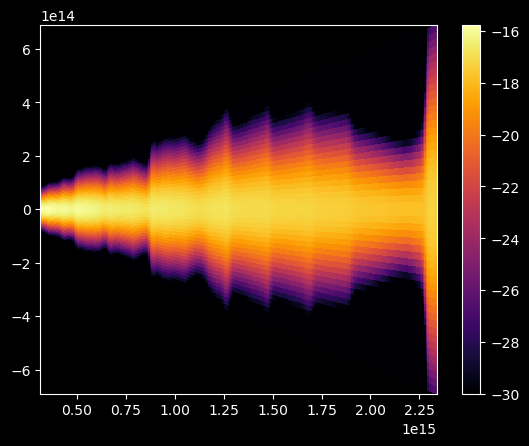

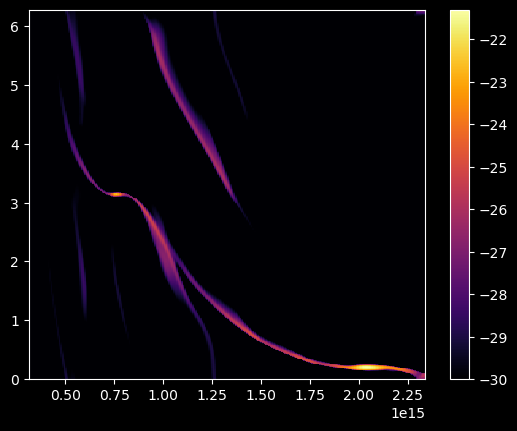

In [24]:
H0 = par.aspectratio*grid1.r0
f = par.flaringindex

coord       = np.meshgrid(grid1.r,grid1.theta,grid1.phi,indexing='ij')
rr       = coord[0]
tt       = coord[1]
pp       = coord[2]
z        = np.cos(tt)*rr

rho = []
for i in range(ndust):
    S_2d  = dens[i+1]
    S_3d  = np.zeros_like(rr)
    H_2d  = H0*(grid1.r/grid1.r0)**(1+f)
    H_2d  = np.meshgrid(H_2d,grid1.phi,indexing='ij')
    H_2d  = H_2d[0]
    H_2d *= np.sqrt(par.alpha/(par.alpha+St[i][:,:]))
    H_3d  = np.zeros_like(rr)
    for it in range(grid1.ntheta):
        S_3d[:,it,:] = S_2d[:,:]
        H_3d[:,it,:] = H_2d[:,:]
    rho.append(( S_3d / (np.sqrt(2.0*np.pi)*H_3d) ) * np.exp(-(z**2/H_3d**2)/2.0)) ## Power law gaussian


rho = np.array(rho)
plt.loglog(grid1.r/au,rho[0,:,:,0].sum(axis=-1))
plt.xlabel("Radio [AU]")
plt.ylabel("Density")
plt.grid(alpha=0.8)
plt.show()

plt.pcolormesh(rr[:,:,0],z[:,:,0],np.log10(rho[0,:,:,0]),vmin=-30)
plt.colorbar()
plt.show()

plt.pcolormesh(rr[:,0,:],pp[:,0,:],np.log10(rho[0,:,0,:]),vmin=-30)
plt.colorbar()
plt.show()

In [25]:
# Density input is created from FARGO3D for RADMC3D
dens_inp(grid1,rho,ndust)

In [26]:
class wavelength:
    def __init__(self,lmin,lmax,nl):
        self.lmin = lmin
        self.lmax = lmax
        self.nlam = nl
        self.lam  = np.logspace(np.log10(lmin),np.log10(lmax),nl)
        
wl = wavelength(0.1,1e4,10)
wavelength_inp(wl) # this creates an input file called 'wavelength_micron.inp'

In [27]:
class stars:
    def __init__(self,p,T,R,M):
        self.x,self.y,self.z = p[0], p[1], p[2]
        self.T = T
        self.R = R
        self.M = M
        
allstars = []
Star1 = stars([0,0,0],6000.0,7e10,2e33)
allstars.append(Star1)
stars_inp(allstars,wl) # this creates a file 'stars.inp'

In [ ]:
for i in range(ndust): 
    fac1 = sizes[i]/np.sqrt(10)*1e4
    fac2 = sizes[i]*np.sqrt(10)*1e4
    ! optool -radmc -l wavelength_micron.inp -a {fac1} {fac2} 3.5 10
    ! cp dustkappa.inp dustkappa_{names[i+1]}.inp

In [29]:
dustopac_inp(names[1:]) # this creates a file called 'dustopac.inp'. The main purpose of this file is to
                         # tell the code how many dust species there are and where to find the according
                         # opacities

In [30]:
nphot_therm = 1e7
nphot_scat  = 1e6
nphot_spec  = 1e4
scattering_mode_max = 1
nthreads=8
radmc3d_inp(nphot_therm,nphot_scat,nphot_spec,
            scattering_mode_max,nthreads,mrw=0) # this creates a file called 'radmc3d.inp'
                                 # which more generally defines how the code
                                 # will be executed and which methods will
                                 # be employed.

In [ ]:
! radmc3d mctherm secondorder

In [ ]:
! radmc3d sed incl 0

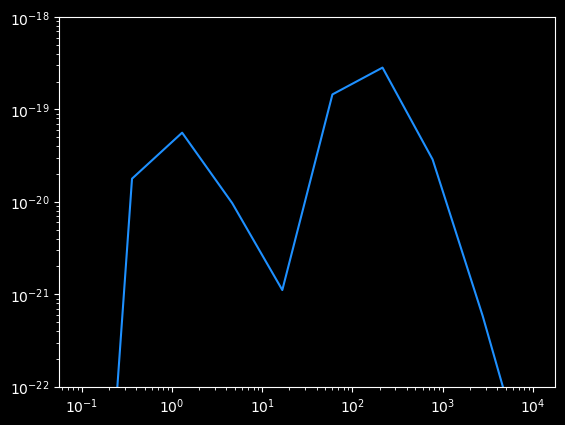

In [36]:
wls, sed = read_spectrum('spectrum.out',wl)
plt.loglog(wls,sed,c='dodgerblue')
plt.ylim(1e-22,1e-18)
plt.show()

In [ ]:
! radmc3d image lambda 1000. incl 45 posang 32

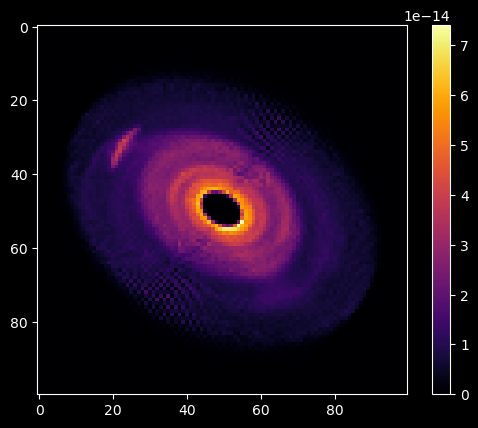

In [38]:
plt.style.use("dark_background")
im = read_image('image.out')
plt.imshow(im)
plt.colorbar()
plt.show()
plt.close()